### Модель прогноза визитов в Яндекс.Браузере в России на 2020–2021 годы
### (Model of forecasting for visits to Yandex.Browser in Russia for 2020–2021)

**Загрузка библиотек (Loading libraries)**

In [1]:
# для анализа
import pandas as pd
import numpy as np
import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# для визуализации
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (15, 7)

**Чтение и обработка файла с данными (Reading and processing file with dataset)**

***Комментарий:*** Данные предварительно были скачаны с ресурса https://radar.yandex.ru/browsers?period=all&selected_rows=RysHuf (The dataset was loaded from source https://radar.yandex.ru/browsers?period=all&selected_rows=RysHuf)

In [2]:
# Открываем файл
pd.options.display.max_columns = 27
df = pd.read_csv('Браузеры в России - по датам 2015-01-01-2019-12-14.csv', sep=',')
df.head()

,Время,"Amigo, Визиты","Amigo, Доля","UC Browser, Визиты","UC Browser, Доля","Internet Explorer, Визиты","Internet Explorer, Доля","Firefox, Визиты","Firefox, Доля","Android Browser, Визиты","Android Browser, Доля","Opera, Визиты","Opera, Доля","Safari, Визиты","Safari, Доля","Яндекс.Браузер, Визиты","Яндекс.Браузер, Доля","Google Chrome, Визиты","Google Chrome, Доля","Edge, Визиты","Edge, Доля","Samsung Internet, Визиты","Samsung Internet, Доля","MIUI browser, Визиты","MIUI browser, Доля","Остальные, Визиты","Остальные, Доля"
0,2015-01-01 - 2015-01-01,5650314,0.020429,1205522,0.004359,22226920,0.080361,25553596,0.092389,13790904,0.049861,41333263,0.149440,24254261,0.087691,33888344,0.122523,102390219,0.370192,0,0.0,0,0.0,0,0.0,6293680,0.022755
1,2015-01-02 - 2015-01-02,6475543,0.019703,1420177,0.004321,26554457,0.080795,30496818,0.092790,16286990,0.049555,49074853,0.149315,28569642,0.086926,40384859,0.122875,121983494,0.371147,0,0.0,0,0.0,0,0.0,7419046,0.022573
2,2015-01-03 - 2015-01-03,6754960,0.019513,1502719,0.004341,28247195,0.081597,32167202,0.092921,17306599,0.049993,51123736,0.147680,29902834,0.086380,42639598,0.123172,128737385,0.371881,0,0.0,0,0.0,0,0.0,7796482,0.022522
3,2015-01-04 - 2015-01-04,6807505,0.019372,1531380,0.004358,28584711,0.081344,32719689,0.093111,17410389,0.049545,52316513,0.148878,30195905,0.085929,42955546,0.122239,130970965,0.372705,0,0.0,0,0.0,0,0.0,7913791,0.022520
4,2015-01-05 - 2015-01-05,6967144,0.019068,1550434,0.004243,30678712,0.083961,34468621,0.094333,17803659,0.048725,54236000,0.148432,30959523,0.084729,44577008,0.121997,136046820,0.372330,0,0.0,0,0.0,0,0.0,8105259,0.022182


In [3]:
# Преобразование данных в нужный формат и удаление лишних колнок
yand_df = pd.DataFrame(df[['Время', 'Яндекс.Браузер, Визиты','Яндекс.Браузер, Доля']])
yand_df['Date']=yand_df['Время'].str[0:10].astype('datetime64[ns]')
yand_df['Date'] = pd.date_range(start='2015-01-01', end='2019-12-14', freq='D')
yand_df = yand_df.rename(columns={'Время': 'Time', 'Яндекс.Браузер, Визиты': 'Visits', 'Яндекс.Браузер, Доля': 'Shares'})
yand_df.index = yand_df.Date
yand_df.index = pd.to_datetime(yand_df.index)
yand_df.head()

,Time,Visits,Shares,Date
Date,,,,
2015-01-01,2015-01-01 - 2015-01-01,33888344,0.122523,2015-01-01
2015-01-02,2015-01-02 - 2015-01-02,40384859,0.122875,2015-01-02
2015-01-03,2015-01-03 - 2015-01-03,42639598,0.123172,2015-01-03
2015-01-04,2015-01-04 - 2015-01-04,42955546,0.122239,2015-01-04
2015-01-05,2015-01-05 - 2015-01-05,44577008,0.121997,2015-01-05


In [4]:
yand = pd.DataFrame(yand_df[['Date', 'Visits']])
yand.head()

,Date,Visits
Date,,
2015-01-01,2015-01-01,33888344
2015-01-02,2015-01-02,40384859
2015-01-03,2015-01-03,42639598
2015-01-04,2015-01-04,42955546
2015-01-05,2015-01-05,44577008


In [5]:
# Группировка данных в период по неделям (кол-во визитов по дням суммируется) 
df_week = yand.resample('W').sum()
df_week.head()

,Visits
Date,
2015-01-04,159868347
2015-01-11,327999377
2015-01-18,351278446
2015-01-25,367119713
2015-02-01,368903905


**Определение наличия тренда (Trend detection)**

In [6]:
# Проверка временного ряда на случайное блуждание, с помощью теста Дики — Фуллера (определение наличия тренда)
diff1lev = df_week['Visits'].diff(1).dropna()
test = adfuller(diff1lev, maxlag=52)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -2.1646329923799055
p-value:  0.2193310429681557
Critical values:  {'1%': -3.4626576734812318, '5%': -2.8757444215841326, '10%': -2.5743412314098753}
есть единичные корни, ряд не стационарен


***Комментарий:*** Наличие тренда подтверждается. (Trend detected)

**Выбор порядка авторегрессионной модели с помощью методов ACF и PACF (Choose an autoregressive model using ACF and PACF methods)**

In [7]:
# Приведение временного ряда к стационарному значению
diff1lev_season = diff1lev.diff(52).dropna()
diff1lev_season1lev = diff1lev_season.diff().dropna()
print ('p.value: %f' % adfuller(diff1lev_season1lev, maxlag=52)[1])

p.value: 0.000000


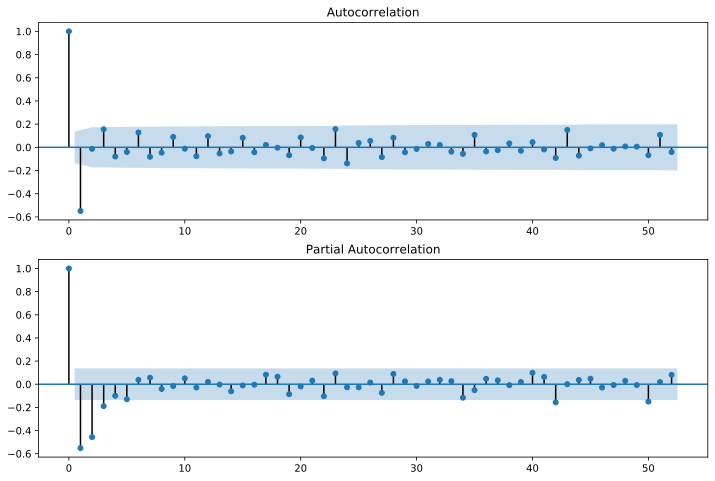

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff1lev_season1lev.values.squeeze(), lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff1lev_season1lev.values.squeeze(), lags=52, ax=ax2)

**Определение наличие сезонности (Seasonality determination)**

In [9]:
result = seasonal_decompose(df_week, model='additive')
print(result.trend.mean())
print(result.seasonal.mean())
print(result.resid.mean())
print(result.observed.mean())

Visits    6.778433e+08
dtype: float64
Visits   -174550.90517
dtype: float64
Visits    2.577035e+06
dtype: float64
Visits    6.684908e+08
dtype: float64


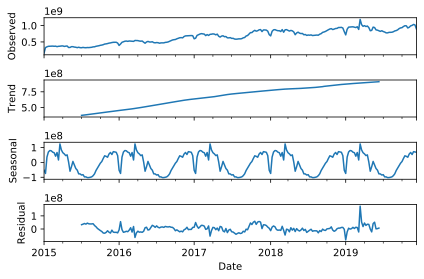

In [10]:
result.plot();

**Построение и обучение модели SARIMAX (Building and learning model SARIMAX)**

In [11]:
%%time

order = (2, 1, 1)
seasonal_order = (1, 1, 0, 52)
model = SARIMAX(df_week, order=order, seasonal_order=seasonal_order)
start_params = np.r_[[0] * (model.k_params - 1), 1]
res = model.fit(start_params = start_params)

Wall time: 6min 57s


In [12]:
df_predict = pd.DataFrame()
df_predict['past'] = df_week.Visits.append(res.forecast(104))
df_predict['future'] = res.forecast(104)

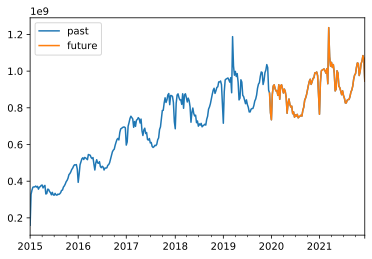

In [13]:
df_predict.plot();

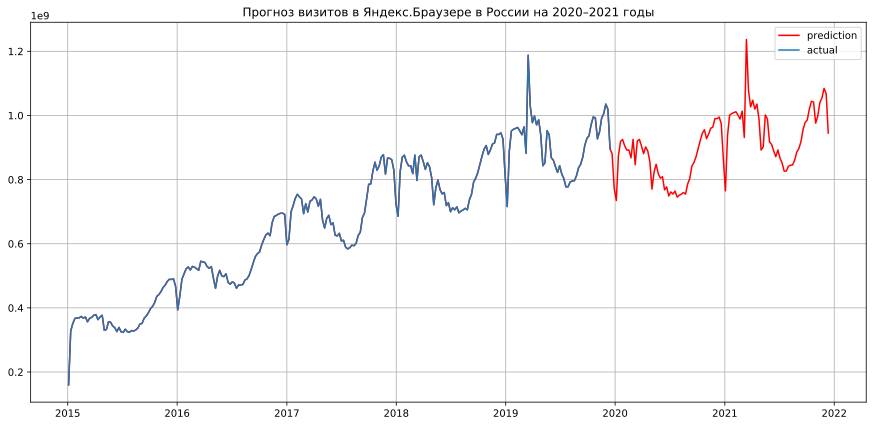

In [14]:
# Прогноз визитов в Яндекс.Браузере в России на 2020–2021 годы
plt.figure(figsize=(15, 7))
plt.plot(df_predict['past'], "r", label="prediction")
plt.plot(df_week, label="actual")
plt.legend(loc="best")
plt.title("Прогноз визитов в Яндекс.Браузере в России на 2020–2021 годы")
plt.grid(True)
plt.savefig('yand_predict.png');